In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.metrics import structural_similarity as ssim

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsClassifier

from sklearn import tree
from sklearn import ensemble

In [42]:
np.set_printoptions(threshold=10000)

In [43]:
def draw_fruits(arr, ratio=1):
    n = len(arr) # 샘플 개수
    rows = int(np.ceil(n / 10))
    cols = n if rows < 2 else 10
    fig, axs = plt.subplots(rows, cols, figsize=(cols*ratio, rows*ratio), squeeze=False)
    for i in range(rows):
        for j in range(cols):
            if i*10 + j < n:
                axs[i, j].imshow(arr[i*10 + j], cmap='gray_r')
            axs[i, j].axis('off')
    plt.show()

In [44]:
def accuracy(y_target, y_pred):
    return np.sum(y_target == y_pred) / len(y_pred)

In [45]:
fruits = np.load('fruits_360_new.npy')
fruits_2d = fruits.reshape(-1, 100*100)

In [46]:
type_start_idx = [0, 936, 1876, 2326, 3028, 3478, 3928]
name_start_idx = [0, 492, 936, 1426, 1876, 2326, 3028, 3478, 3928, 4228]

# 1. 데이터셋 살펴보기

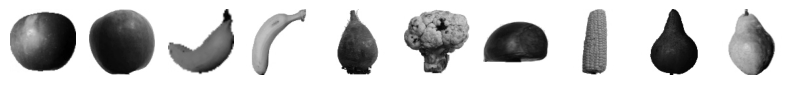

In [47]:
arr = [fruits[idx].reshape(100, 100) for idx in name_start_idx]
draw_fruits(arr)

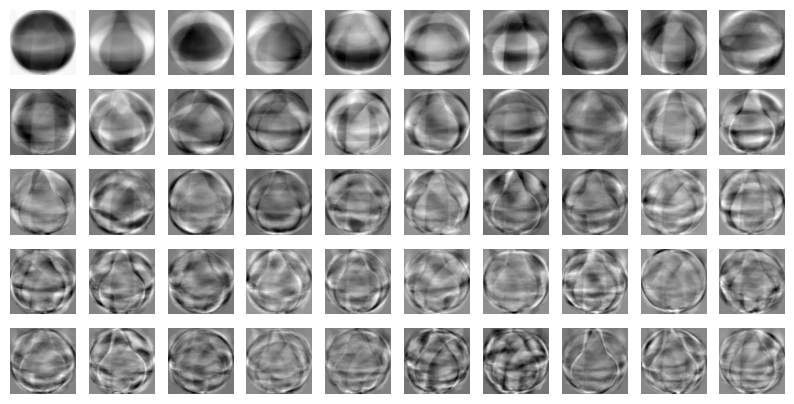

In [48]:
pca_50 = PCA(n_components=50)
pca_50.fit(fruits_2d)
draw_fruits(pca_50.components_.reshape(-1, 100, 100))

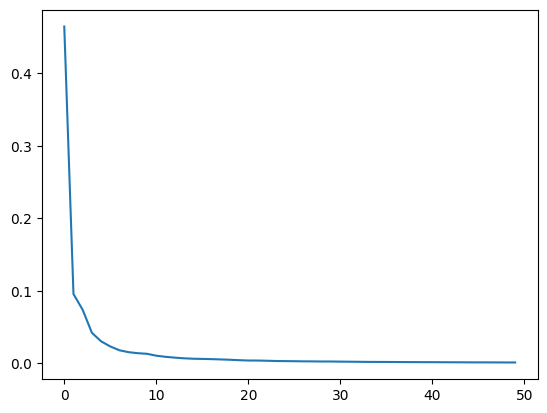

In [49]:
plt.plot(pca_50.explained_variance_ratio_)

In [50]:
# 10000개의 특징을 50개로 축소
fruits_pca_50 = pca_50.transform(fruits_2d)

In [51]:
# 축소된 특징 복원
fruits_pca_inv_50 = pca_50.inverse_transform(fruits_pca_50)

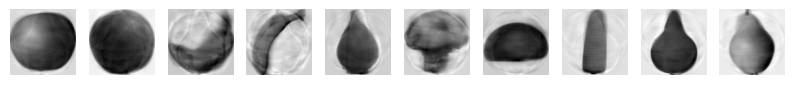

In [52]:
arr = [fruits_pca_inv_50[idx].reshape(100, 100) for idx in name_start_idx]
draw_fruits(arr)

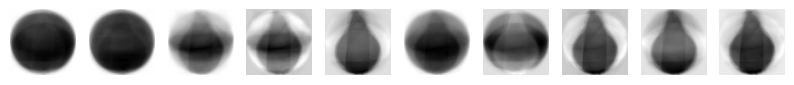

In [53]:
pca_2 = PCA(n_components=2)
pca_2.fit(fruits_2d)
fruits_pca_2 = pca_2.transform(fruits_2d)
fruits_pca_inv_2 = pca_2.inverse_transform(fruits_pca_2)
arr = [fruits_pca_inv_2[idx].reshape(100, 100) for idx in name_start_idx]
draw_fruits(arr)

# 2. 데이터셋 구성

## 2-1. 데이터셋 구성

In [54]:
df_fruits = pd.DataFrame(fruits_2d)

target = np.concatenate([[0]*(type_start_idx[1] - type_start_idx[0]),
                         [1]*(type_start_idx[2] - type_start_idx[1]),
                         [2]*(type_start_idx[3] - type_start_idx[2]),
                         [3]*(type_start_idx[4] - type_start_idx[3]),
                         [4]*(type_start_idx[5] - type_start_idx[4]),
                         [5]*(type_start_idx[6] - type_start_idx[5]),
                         [6]*(4718 - type_start_idx[6]),
                         ])

df_fruits.insert(0, column='fruit', value=target)
tot_input_vars = df_fruits.columns[df_fruits.columns != 'fruit']

## 2-2. PCA 기반 2차원 축소 후 label 별 도식화

In [55]:
def plot_matplotlib_df(df, input_var, target_var, scaler=StandardScaler, point=None):
    df = df.copy()
    X = df[input_var]
    Y = df[target_var]

	# 데이터 분할
    X_train, X_test, Y_train, Y_test =\
		train_test_split(X, Y, test_size=0.25, random_state=42)

	# Scaling
	# y는 범주형 데이터이므로 scaling 불필요
    s_x = scaler()
    s_x.fit(X_train)
    X_train = s_x.transform(X_train)
    X_test = s_x.transform(X_test)

    pca = PCA(n_components=2)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=Y_train, ax=ax[0], palette='deep')
    sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=Y_test, ax=ax[1], palette='deep')
    if point is not None:
        ax[0].scatter(X_train[point, 0], X_train[point, 1], marker='^')

    ax[0].set_title("train set")
    ax[1].set_title("test set")
    ax[0].get_legend().remove()
    ax[1].legend(bbox_to_anchor=(-0.03, 1.03))

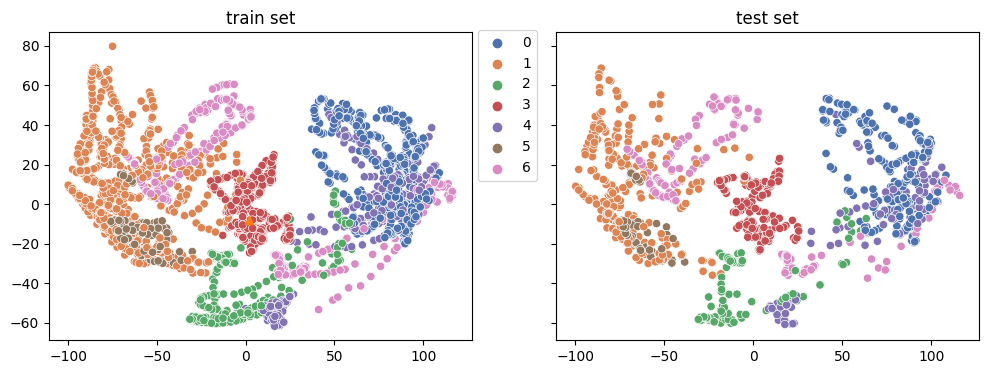

In [56]:
plot_matplotlib_df(df_fruits, tot_input_vars, 'fruit', point=0)

# 3. 10000개의 Fature 기반 다중 회귀 분석 성능 분석

In [57]:
def reg_df_eval(df, input_var, target_var, split_ratio=0.25, scaler=StandardScaler,
                degree=2, method="linear", alpha=None):
    methods = {"linear": LinearRegression, "ridge": Ridge, "lasso": Lasso}

    df = df.copy()
    X = df[input_var]
    Y = df[target_var]

    X_train, X_test, Y_train, Y_test =\
		train_test_split(X, Y, test_size=split_ratio, random_state=42)

    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly.fit(X_train)
    X_train_poly = poly.transform(X_train)
    X_test_poly = poly.transform(X_test)

    if scaler:
        s_x, s_y = scaler(), scaler()
        s_x.fit(X_train_poly)
        s_y.fit(Y_train)
        X_train = s_x.transform(X_train_poly)
        X_test = s_x.transform(X_test_poly)
        Y_train = s_y.transform(Y_train)
        Y_test = s_y.transform(Y_test)

	# 회귀 분석 모델 초기화
    if method == 'linear':
        lr = methods.get(method)()
    else:
        lr = methods.get(method)(alpha=alpha, max_iter=100000)
    lr.fit(X_train, Y_train)
    
    r2_train = r2_score(Y_train, lr.predict(X_train))
    r2_test = r2_score(Y_test, lr.predict(X_test))
    
    print(f"[r^2 score] train : {r2_train}, test : {r2_test}")
    
    return lr, r2_train, r2_test

## 3-1. 10000개의 Feature 기반 LinearRegression 성능 분석

In [60]:
reg_df_eval(df_fruits, list(range(10000)), ['fruit'], degree=1, method='linear')

[r^2 score] train : 1.0, test : 0.9137073432824452


(LinearRegression(), 1.0, 0.9137073432824452)

## 3-2. 10000개의 Feature 기반 Lasso 성능 분석

In [ ]:
reg_df_eval(df_fruits, list(range(10000)), ['fruit'], degree=1, method='lasso', alpha=0.001)

[r^2 score] train : 0.9792077795488825, test : 0.9167727392452958


(Lasso(alpha=0.001, max_iter=100000), 0.9792077795488825, 0.9167727392452958)

## 3-3. 10000개의 Feature 기반 Ridge 성능 분석

In [61]:
reg_df_eval(df_fruits, list(range(10000)), ['fruit'], degree=1, method='ridge', alpha=0.01)

[r^2 score] train : 0.9999999980377672, test : 0.9137159603418762


(Ridge(alpha=0.01, max_iter=100000), 0.9999999980377672, 0.9137159603418762)

# 4. 10000개의 Feature 기반 feature selection 및 성능 분석

In [62]:
def train_test_df(df, input_var, target_var, split_ratio=0.25, scaler=StandardScaler):
    df = df_fruits.copy()
    X = df[input_var]
    Y = df[target_var]
    X_train, X_test, Y_train, Y_test =\
        train_test_split(X, Y, test_size=split_ratio, 
                            random_state=42)

    s_x, s_y = scaler(), scaler()
    s_x.fit(X_train)
    s_y.fit(Y_train)
    X_train = s_x.transform(X_train)
    X_test = s_x.transform(X_test)
    Y_train = s_y.transform(Y_train)
    Y_test = s_y.transform(Y_test)

    return X_train, X_test, Y_train, Y_test

In [63]:
X_train, X_test, Y_train, Y_test = train_test_df(df_fruits, list(range(10000)), ['fruit'])
n_feature = [1, 2, 10, 100, 1000, 10000]
for i in n_feature:
    kbest = SelectKBest(f_regression, k=i).fit(X_train, Y_train.reshape(-1))
    X_train_k = kbest.transform(X_train)
    X_test_k = kbest.transform(X_test)
    print(X_train_k.shape, end="\t")
    lr = LinearRegression()
    lr.fit(X_train_k, Y_train)
    r2_train = r2_score(Y_train, lr.predict(X_train_k))
    r2_test = r2_score(Y_test, lr.predict(X_test_k))
    mse_train = mean_squared_error(Y_train, lr.predict(X_train_k))

    print(r2_train, r2_test, mse_train)

(3538, 1)	0.18741702424533868 0.15692756673997799 0.8125829757546612
(3538, 2)	0.1905047896671891 0.16017463526808862 0.8094952103328108
(3538, 10)	0.29646103746171926 0.30349278045687145 0.7035389625382806
(3538, 100)	0.3896408949893081 0.39074451836290747 0.6103591050106918
(3538, 1000)	0.7469266177072647 0.5617379961647708 0.25307338229273524
(3538, 10000)	1.0 0.9136821535554521 5.810630063314381e-29


# 5. 10000개의 feature 기반 feature extraction 및 성능 분석

In [65]:
X_train, X_test, Y_train, Y_test = train_test_df(df_fruits, list(range(10000)), ['fruit'])
n_feature = [1, 2, 10, 100]
for i in n_feature:
    pca = PCA(n_components=i).fit(X_train)
    X_train_p = pca.transform(X_train)
    X_test_p = pca.transform(X_test)
    print(X_train_p.shape, end="\t")
    lr = LinearRegression()
    lr.fit(X_train_p, Y_train)
    r2_train = r2_score(Y_train, lr.predict(X_train_p))
    r2_test = r2_score(Y_test, lr.predict(X_test_p))
    mse_train = mean_squared_error(Y_train, lr.predict(X_train_p))

    print(r2_train, r2_test, mse_train)

(3538, 1)	0.042995359015727486 0.050406629929388935 0.9570046409842724
(3538, 2)	0.05904675180637475 0.07415210683017648 0.9409532481936251
(3538, 10)	0.29061653471356097 0.3275141425206486 0.7093834652864389
(3538, 100)	0.7818194255869435 0.7693473501058966 0.2181805744130565


# 6. KNN

In [ ]:
def c_knn_df(df, input_var, target_var, scaler=StandardScaler, n_neighbors=5):
    df = df.copy()
    X = df[input_var]
    Y = df[target_var]

    X_train, X_test, Y_train, Y_test =\
		train_test_split(X, Y, random_state=42)
    if scaler:
        s_x = scaler()
        s_x.fit(X_train)
        X_train = s_x.transform(X_train)
        X_test = s_x.transform(X_test)

    knc = KNeighborsClassifier(n_neighbors=n_neighbors)
    knc.fit(X_train, Y_train.to_numpy())

    s_train = knc.score(X_train, Y_train)
    s_test = knc.score(X_test, Y_test)

    print(f"[score] train : {s_train}, test : {s_test}")

    return knc, s_x, X_train, Y_train, X_test, Y_test

In [ ]:
knc, s_x, x_train, y_train, x_test, y_test = c_knn_df(df_fruits, list(range(10000)), 'fruit')

[score] train : 0.9994347088750707, test : 0.9966101694915255


# 7. 로지스틱 회귀

In [ ]:
def c_logistic_df(df, input_var, target_var, target_value=None, scaler=StandardScaler, C=1):
    df = df.copy()
    X = df[input_var]
    Y = df[target_var]

    if target_value is not None:
        Y = Y.apply(lambda x: 1 if x == target_value else 0)

    X_train, X_test, Y_train, Y_test =\
        train_test_split(X, Y, random_state=42)

    if scaler:
        s_x = scaler()
        s_x.fit(X_train)
        X_train = s_x.transform(X_train)
        X_test = s_x.transform(X_test)

    # Logistic Regression 모델 초기화
    lr = LogisticRegression(C=C, max_iter=10000)
    lr.fit(X_train, Y_train.to_numpy())

    s_train = lr.score(X_train, Y_train)
    s_test = lr.score(X_test, Y_test)

    print(f"[score] train : {s_train}, test : {s_test}")

    return lr, s_x

In [ ]:
lr, s_x = c_logistic_df(df_fruits, list(range(10000)), 'fruit')

c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[score] train : 1.0, test : 0.9991525423728813


# 8. Decision Tree

In [ ]:
def c_decision_tree_df(df, input_var, target_var, max_depth=None):
    df = df.copy()
    X = df[input_var]
    Y = df[target_var]

	# 데이터 분할
    X_train, X_test, Y_train, Y_test =\
	    train_test_split(X, Y, random_state=42)

    # Decision Tree 모델 초기화
    lr = tree.DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    lr.fit(X_train, Y_train.to_numpy())

    s_train = lr.score(X_train, Y_train.to_numpy())
    s_test = lr.score(X_test, Y_test.to_numpy())

    print(f"[score] train : {s_train}, test : {s_test}")

    return lr

In [ ]:
lr = c_decision_tree_df(df_fruits, list(range(10000)), 'fruit')

[score] train : 1.0, test : 0.988135593220339


In [ ]:
lr.get_depth()

10

In [ ]:
for i in range(3, 12):
    print(f'[{i}] ', end='\t')
    c_decision_tree_df(df_fruits, list(range(10000)), 'fruit', max_depth=i)

[3] 	[score] train : 0.5672696438665913, test : 0.5525423728813559
[4] 	[score] train : 0.676088185415489, test : 0.6584745762711864
[5] 	[score] train : 0.815432447710571, test : 0.7838983050847458
[6] 	[score] train : 0.9126625211984172, test : 0.9059322033898305
[7] 	[score] train : 0.9739966082532504, test : 0.9584745762711865
[8] 	[score] train : 0.9951950254381006, test : 0.9745762711864406
[9] 	[score] train : 0.9997173544375353, test : 0.9838983050847457
[10] 	[score] train : 1.0, test : 0.988135593220339
[11] 	[score] train : 1.0, test : 0.988135593220339


# 9. Random Forest

In [ ]:
def c_random_forest_df(df, input_var, target_var, max_depth=None):
    df = df.copy()
    X = df[input_var]
    Y = df[target_var]
    
	# 데이터 분리
    X_train, X_test, Y_train, Y_test =\
	    train_test_split(X, Y, random_state=42)
    
    lr = ensemble.RandomForestClassifier(max_depth=max_depth, random_state=42, n_jobs=-1, oob_score=True)
    lr.fit(X_train, Y_train.to_numpy())
    
    s_train = lr.score(X_train, Y_train.to_numpy())
    s_test = lr.score(X_test, Y_test.to_numpy())
    
    print(f"[score] train : {s_train}, test : {s_test}")
    
    return lr

In [72]:
lr = c_random_forest_df(df_fruits, list(range(10000)), 'fruit')

[score] train : 1.0, test : 1.0


# 10. Extra Trees

In [74]:
def c_extra_trees_df(df, input_var, target_var, max_depth=None, n_estimators=100):
    df = df.copy()
    X = df[input_var]
    Y = df[target_var]
    
    X_train, X_test, Y_train, Y_test =\
        train_test_split(X, Y, random_state=42)
    
    lr = ensemble.ExtraTreesClassifier(max_depth=max_depth, random_state=42, n_jobs=-1, n_estimators=n_estimators)
    lr.fit(X_train, Y_train.to_numpy())
    
    s_train = lr.score(X_train, Y_train.to_numpy())
    s_test = lr.score(X_test, Y_test.to_numpy())
    
    print(f"[score] train : {s_train}, test : {s_test}")
    
    return lr

In [75]:
lr = c_extra_trees_df(df_fruits, list(range(10000)), 'fruit')

[score] train : 1.0, test : 1.0


# 11. KMeans

In [76]:
X_train, X_test, Y_train, Y_test = train_test_df(df_fruits, list(range(10000)), ['fruit'])
km = KMeans(n_clusters=7, random_state=42, n_init=1)
km.fit(X_train)

KMeans(n_clusters=7, n_init=1, random_state=42)

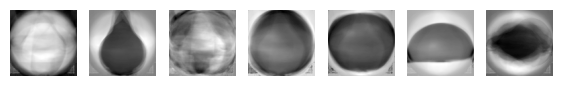

In [77]:
draw_fruits(km.cluster_centers_.reshape(-1, 100, 100))

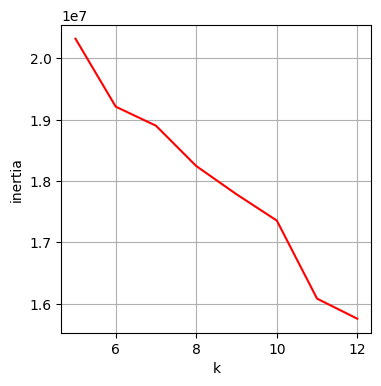

In [78]:
inertias, scores = [], []
x = list(range(5, 13))
for k in x:
    km = KMeans(n_clusters=k, random_state=42, n_init=1)
    km.fit(X_train)
    inertias.append(km.inertia_)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(x, inertias, color='r', label='inertias')
ax.set_xlabel('k')
ax.set_ylabel('inertia')
ax.grid(True)

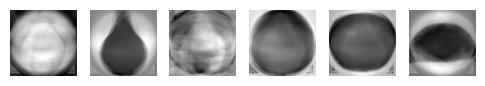

In [79]:
km = KMeans(n_clusters=6, random_state=42, n_init=1).fit(X_train)
draw_fruits(km.cluster_centers_.reshape(-1, 100, 100))

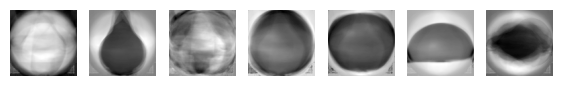

In [80]:
km = KMeans(n_clusters=7, random_state=42, n_init=1).fit(X_train)
draw_fruits(km.cluster_centers_.reshape(-1, 100, 100))

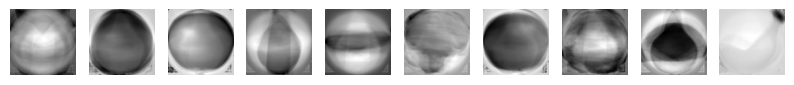

In [81]:
km = KMeans(n_clusters=10, random_state=42, n_init=1).fit(X_train)
draw_fruits(km.cluster_centers_.reshape(-1, 100, 100))